In [39]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

!pip install tensorflow-addons
import tensorflow_addons as tfa

import itertools

tf.random.set_seed(1)

In [40]:
import pickle

images = pickle.load( open('../../CROHME_extractor/outputs/train/train.pickle', 'rb') )

In [41]:
images[0]

{'features': array([1, 1, 1, ..., 1, 1, 1], dtype=uint8),
 'label': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0], dtype=int8)}

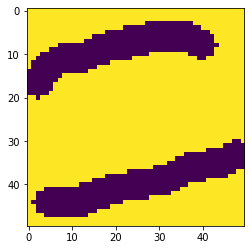

In [42]:
from matplotlib import pyplot as plt
plt.imshow(image1)

In [43]:
classes = pd.read_csv('../../CROHME_extractor/classes.txt', header =None)

In [44]:
classes.to_dict()[0]

{0: '(',
 1: ')',
 2: '+',
 3: '-',
 4: '0',
 5: '1',
 6: '2',
 7: '3',
 8: '4',
 9: '5',
 10: '6',
 11: '7',
 12: '8',
 13: '9',
 14: '=',
 15: 'a',
 16: 'b',
 17: 'c',
 18: 'd',
 19: 'e',
 20: 'i',
 21: 'j',
 22: 'k',
 23: 'n',
 24: 'x',
 25: 'y',
 26: 'z'}

In [45]:
X_train = []
y_train = []
for i in images:
    X_train.append(np.resize(i['features'], (50,50,1)))
    y_train.append(i['label'])

In [46]:
X_train[0].shape

(50, 50, 1)

In [47]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [48]:
X_train=1-X_train

In [49]:
y_train = np.argmax(y_train, axis=1)

In [50]:
X_train.shape

(9122, 50, 50, 1)

In [51]:
y_train.shape

(9122,)

In [71]:
X_train.shape[0]

9122

In [80]:
X_train = tfa.image.rotate(X_train, 20*3.14/180, interpolation='BILINEAR')

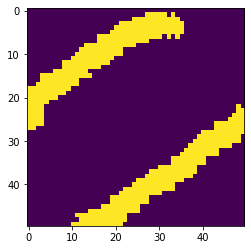

In [79]:
plt.imshow(X_train[0])

In [135]:
X_train.shape

TensorShape([9122, 50, 50, 1])

In [136]:
def build_model(conv_layers, pool_layers, epochs, X_train, y_train,k):
    cnn_model = build_cnn(conv_layers, pool_layers,k)
  
    

    # Define a loss function
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

    # Compile the model
    cnn_model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

    history = cnn_model.fit(X_train, y_train, epochs=epochs, validation_split=0.3)

    plot_history(history, epochs)

    confusionmatrix(model= cnn_model)

    return history

In [137]:
def build_cnn(conv_layers, pool_layers, k):
    model_cnn = Sequential()
    model_cnn.add(Conv2D(60, kernel_size=k,activation='relu',input_shape=(50,50,1),padding='same'))
    model_cnn.add(MaxPooling2D((2, 2), padding='same'))
    model_cnn.add(Dropout(0.4))
    x=45
    for i in range(1, conv_layers):
        if i <= conv_layers-1:        
            model_cnn.add(Conv2D(x, kernel_size=k,activation='relu',padding='same'))
            model_cnn.add(MaxPooling2D((2, 2), padding='same'))
            model_cnn.add(Dropout(0.4))
            x=x-15
    model_cnn.add(Flatten())
    model_cnn.add(Dense(128))
    model_cnn.add(Dense(80))
    model_cnn.add(Dense(27, activation='softmax'))

    print(model_cnn.summary())
    return model_cnn

In [138]:
def plot_history(history, epochs):
    epochs = range(epochs)

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, train_acc, color='blue', label='Training accuracy')
    plt.plot(epochs, val_acc, color='red', label='Validation accuracy')
    plt.legend()
    plt.grid()

In [139]:
def confusionmatrix(model):

    confusion = confusion_matrix(y_test, np.argmax(model.predict(X_test), axis=-1))

    confusion_norm = confusion.astype('float') / confusion.sum(axis=0)[:, np.newaxis]

    classes=[0,1,2,3,4,5,6,7,8,9]

    plt.figure(figsize=(14,14))
    plt.imshow(confusion_norm, interpolation='nearest') 
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=45) 
    plt.yticks(tick_marks, classes)
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    fmt = '.3f'
    thresh = confusion_norm.max() / 2.
    for i, j in itertools.product(range(confusion_norm.shape[0]), range(confusion_norm.shape[1])):
        plt.text(j, i, format(confusion_norm[i, j], fmt), horizontalalignment="center",
        color="black" if confusion_norm[i, j] > thresh else "white")
    plt.tight_layout()

In [140]:
build_model(conv_layers=4, pool_layers=4, epochs=30, X_train=X_train, y_train=y_train, k=5)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 50, 50, 60)        1560      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 25, 25, 60)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 25, 25, 60)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 45)        67545     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 45)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 13, 13, 45)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 30)       

KeyboardInterrupt: 